# Transcribe each word with <span style="color:#E70000">Nasjonalbiblioteket AI Lab </span> 🐦


### Library Imports 🐢

In [2]:
from prettytable import PrettyTable
# from datasets import load_dataset
from IPython.display import display
import self_made_functions as smf
from transformers import pipeline
import matplotlib.pyplot as plt 
from tabulate import tabulate
import seaborn as sns
import pandas as pd 
import numpy as np
# Not in use -> future waring for whisper models
import whisper
import torch
import jiwer
import os
# conda install -n base -c conda-forge jupyterlab_widgets

### Setup for file reading 🐳
Data Frame Columns: [File name, Score, Prosody, Noise/Disruption, Pre-speech noise, Repetition, Word, Pronunciation, pronScores, Assessor]

In [3]:
# Use the correct GPU -------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cuda0" if torch.cuda.is_available() else "cpu" (?)

data_path = '/talebase/data/speech_raw/teflon_no/'
wv_path = data_path + 'speech16khz/'

# Data frame fixing -------------
df_assessment = pd.read_csv(data_path+'assessments.csv') # Reed the csv assessment file 
df_no_dup = df_assessment.drop_duplicates('File name') # Remove all the duplicate names -> nr of dups wiht this: 2821 
# df_no_dup = df_assessment.drop_duplicates() # Remove all the duplicates that are the same -> nr of dupes with this: 2

df_no_zero = df_no_dup.drop(df_no_dup[df_no_dup['Score'] == 0].index) # Drop all the rows with the score 0
df_all_zeros = df_no_dup.drop(df_no_dup[df_no_dup['Score'] != 0].index) # Store all the removed rows with score 0 -- put in report 📚🐲
df_fin = df_no_zero.reset_index(drop=True) # This resets the index after rows was dropped
sampling_rate = 16000


### Check OG word in df

### Testing Whisper by transcribing and assessing one word 🐘
Found: The jiwer is case sensitive, so the whisper version from "Nasjonalbiblioteket AI Lab" needs to be lowered, and the dot at the end needs to be removed.

<span style="color:#E70000"><b> NB! </b></span> Verbatim version: This lower-cased variant is more literal and suitable for tasks requiring detailed transcription, such as linguistic analysis.

<span style="color:#E70000"> Test ut det samme med annen model </span>


#### Trancribing one word for several different models 🐘🐘🐘

Make a function that looks at the transcribed results and get the different transcriptions for one word

In [4]:
# # Example usage:
# file_name = "a27_hylle.wav"  # Specify the file name you want to match
# result_table = smf.extract_row_from_csv(file_name)
# print(result_table)

In [5]:
# test_for_models = ['tiny', 'base', 'medium',
#                     'nb-whisper-tiny', 'nb-whisper-base',  'nb-whisper-medium', 
#                     'nb-whisper-tiny-verbatim', 'nb-whisper-base-verbatim', 'nb-whisper-medium-verbatim']
# smf.update_all_models(test_for_models)

# The verbatium itranss the models that does the best cribing for wave number 7.
# Next look at the words with repetition, and make a script to handle them -- mail julie
# wn = 4
# smf.transcribe_and_show_one_word(wn)

Here we also se that the openai/whisper-tiny is more unstable, and the verbatim version is more stable and better to transcribe. At least the one excample here, now we need to test it for more instences. ((SE what is comented out))
<!-- 
Med ulik transkribering bassert på lest dokumentasjon:
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
|       Model        | Speaker | Speaker Number | Original Word | Transcribed Word | CER | CER Score | OG Word Score | Repetition |
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
|        base        |    a    |       14       |     hylle     |       hilde      | 0.4 |     3     |       5       |    nan     |
|        tiny        |         |                |               |       heen       | 1.0 |     1     |               |            |
|       medium       |         |                |               |       hille      | 0.2 |     4     |               |            |
|      nb-base       |         |                |               |       hille      | 0.2 |     4     |               |            |
|      nb-tiny       |         |                |               |       hygle      | 0.2 |     4     |               |            |
|     nb-medium      |         |                |               |       hylle      | 0.0 |     5     |               |            |
|  nb-base-verbatim  |         |                |               |       hylle      | 0.0 |     5     |               |            |
|  nb-tiny-verbatim  |         |                |               |       hylle      | 0.0 |     5     |               |            |
| nb-medium-verbatim |         |                |               |       hylle      | 0.0 |     5     |               |            |
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|       Model        | Speaker | Speaker Number | Original Word | Transcribed Word | CER  | CER Score | OG Word Score | Repetition |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|        base        |    a    |       14       |     hylle     |       hilde      | 0.4  |     3     |       5       |    nan     |
|        tiny        |         |                |               |      hazenne     | 0.71 |     2     |               |            |
|       medium       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-base       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-tiny       |         |                |               |       hygle      | 0.2  |     4     |               |            |
|     nb-medium      |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-base-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-tiny-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
| nb-medium-verbatim |         |                |               |       hylle      | 0.0  |     5     |               |            |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
|       Model        | Speaker | Speaker Number | Original Word | Transcribed Word | CER | CER Score | OG Word Score | Repetition |
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
|        base        |    a    |       14       |     hylle     |       hilde      | 0.4 |     3     |       5       |    nan     |
|        tiny        |         |                |               |       hïnne      | 0.6 |     2     |               |            |
|       medium       |         |                |               |       hille      | 0.2 |     4     |               |            |
|      nb-base       |         |                |               |       hille      | 0.2 |     4     |               |            |
|      nb-tiny       |         |                |               |       hygle      | 0.2 |     4     |               |            |
|     nb-medium      |         |                |               |       hylle      | 0.0 |     5     |               |            |
|  nb-base-verbatim  |         |                |               |       hylle      | 0.0 |     5     |               |            |
|  nb-tiny-verbatim  |         |                |               |       hylle      | 0.0 |     5     |               |            |
| nb-medium-verbatim |         |                |               |       hylle      | 0.0 |     5     |               |            |
+--------------------+---------+----------------+---------------+------------------+-----+-----------+---------------+------------+
Begge transkriberes med .transcribe() -> fungerer ikke med NL dataen


Begge transkriberes med NL måten
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|       Model        | Speaker | Speaker Number | Original Word | Transcribed Word | CER  | CER Score | OG Word Score | Repetition |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|        base        |    a    |       14       |     hylle     |       hilde      | 0.4  |     3     |       5       |    nan     |
|        tiny        |         |                |               |        yeh       | 1.33 |     1     |               |            |
|       medium       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-base       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-tiny       |         |                |               |       hygle      | 0.2  |     4     |               |            |
|     nb-medium      |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-base-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-tiny-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
| nb-medium-verbatim |         |                |               |       hylle      | 0.0  |     5     |               |            |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|       Model        | Speaker | Speaker Number | Original Word | Transcribed Word | CER  | CER Score | OG Word Score | Repetition |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+
|        base        |    a    |       14       |     hylle     |       hilla      | 0.4  |     3     |       5       |    nan     |
|        tiny        |         |                |               |      heller      | 0.33 |     4     |               |            |
|       medium       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-base       |         |                |               |       hille      | 0.2  |     4     |               |            |
|      nb-tiny       |         |                |               |       hygle      | 0.2  |     4     |               |            |
|     nb-medium      |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-base-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
|  nb-tiny-verbatim  |         |                |               |       hylle      | 0.0  |     5     |               |            |
| nb-medium-verbatim |         |                |               |       hylle      | 0.0  |     5     |               |            |
+--------------------+---------+----------------+---------------+------------------+------+-----------+---------------+------------+ -->


### Transcribing and assessing all the words 🐸 
The transcribed data frame is <span style="color:#E70000"><b> saved as a csv file </b></span>, with the top columns: Word, Transcribed, Wer Error, Score

To do something on a whole column in a df you can use the <code> .apply </code> function. This function takes a function as an argument and applies it to the whole column.

Found out the openAi models does almost not hallusinate at all :O 

Get <b> correct csv name </b> for the empty transcriptions.
It will put the transcript versions into the correct version of the empty transcriptions.
This can be used to se if the model return the same empty transcriptions each time

### Transcribing and assessing all the words for several different models 🐸🐸🐸
 The first transcriptions show that the open/whisper-tiny is more unstable, and the verbatim version gives more stable results. In some cases, the transcription is more correct than the original assessment of the word.
Example her is for the file "a03_synge.wav" | synge | synger | CER: 0.16 | CER score 5 | Original score 3 
The word should not get a better transcription than the assessment of the word. The result is probably to whisper "guessing" what the word most likely is, and therefore guesses correctly despite "bad" pronunciation.

In [6]:
import self_made_functions as smf
# compar the empty rows from different models and se of you can find some common ground. 
# import self_made_functions as smf

# test_for_models = ['tiny', 'base', 'medium',
#                     'nb-whisper-tiny', 'nb-whisper-base',  'nb-whisper-medium', 
#                     'nb-whisper-tiny-verbatim', 'nb-whisper-base-verbatim', 'nb-whisper-medium-verbatim']

# test_for_models = ['tiny', 'base', 'medium']
# test_for_models = ['nb-whisper-tiny', 'nb-whisper-base', 'nb-whisper-medium']
test_for_models = ['nb-whisper-tiny-verbatim', 'nb-whisper-base-verbatim', 'nb-whisper-medium-verbatim']

empty_transcription_path = './Transcriptions/Empty_Transcriptions/'
directory = './Transcriptions'

# for model_name in test_for_models:      
#     # tr, mt = transcribe_all_audio(model_name, empty_translations, save=True)
#     smf.transcribe_all_audio(model_name=model_name, empty_path=empty_transcription_path,
#                             data_path = wv_path, df = df_fin, 
#                             directory=directory, save=True)


    
# The transcribed databases should be sorted by filename after running all the model - see if the results depends on person or word
# Medium used 407 min to run
# Tiny used 23 min to run

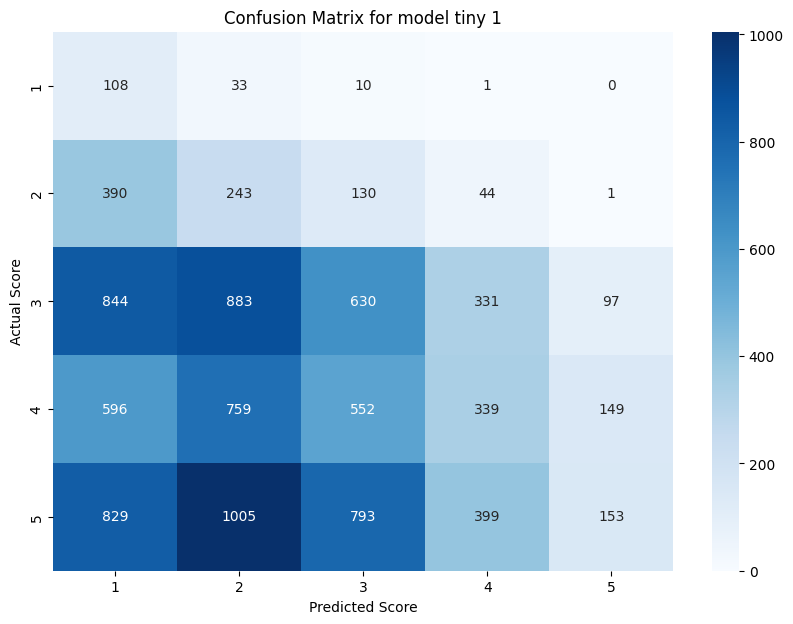

Confusion Matrix:
 [[ 108   33   10    1    0]
 [ 390  243  130   44    1]
 [ 844  883  630  331   97]
 [ 596  759  552  339  149]
 [ 829 1005  793  399  153]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |   0.039   | 0.7105 |  0.7099  |
|    2     |  0.0831   | 0.3007 |  0.6518  |
|    3     |  0.2979   | 0.2262 |  0.6094  |
|    4     |  0.3043   | 0.1415 |  0.6962  |
|    5     |  0.3825   | 0.0481 |  0.6488  |
|   Mean   |  0.2214   | 0.2854 |  0.6632  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0390,0.7105,0.7099
1,2,0.0831,0.3007,0.6518
2,3,0.2979,0.2262,0.6094
3,4,0.3043,0.1415,0.6962
4,5,0.3825,0.0481,0.6488
5,Mean,0.2214,0.2854,0.6632


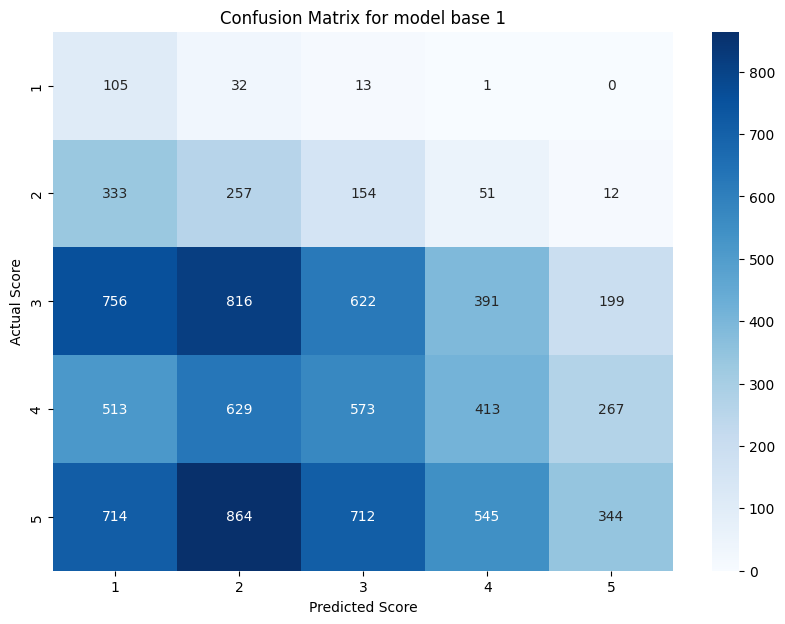

Confusion Matrix:
 [[105  32  13   1   0]
 [333 257 154  51  12]
 [756 816 622 391 199]
 [513 629 573 413 267]
 [714 864 712 545 344]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0434   | 0.6954 |  0.7465  |
|    2     |  0.0989   | 0.3185 |  0.6897  |
|    3     |  0.2999   | 0.2234 |  0.6121  |
|    4     |  0.2948   | 0.1724 |  0.6812  |
|    5     |  0.4185   | 0.1082 |  0.6444  |
|   Mean   |  0.2311   | 0.3036 |  0.6748  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0434,0.6954,0.7465
1,2,0.0989,0.3185,0.6897
2,3,0.2999,0.2234,0.6121
3,4,0.2948,0.1724,0.6812
4,5,0.4185,0.1082,0.6444
5,Mean,0.2311,0.3036,0.6748


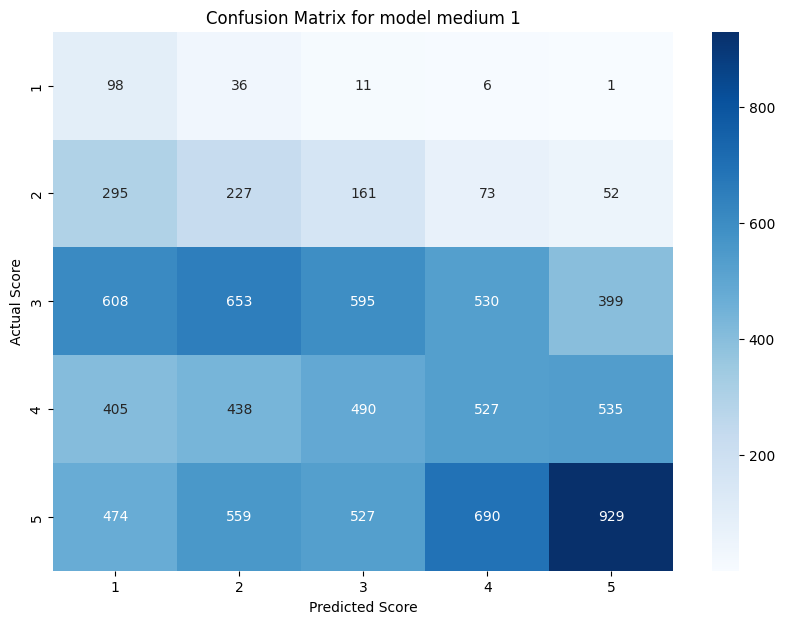

Confusion Matrix:
 [[ 98  36  11   6   1]
 [295 227 161  73  52]
 [608 653 595 530 399]
 [405 438 490 527 535]
 [474 559 527 690 929]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0521   | 0.6447 |  0.803   |
|    2     |  0.1187   | 0.2809 |  0.7567  |
|    3     |  0.3335   | 0.2136 |  0.6374  |
|    4     |  0.2886   |  0.22  |  0.6602  |
|    5     |  0.4849   | 0.2922 |  0.6526  |
|   Mean   |  0.2556   | 0.3303 |  0.702   |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0521,0.6447,0.8030
1,2,0.1187,0.2809,0.7567
2,3,0.3335,0.2136,0.6374
3,4,0.2886,0.2200,0.6602
4,5,0.4849,0.2922,0.6526
5,Mean,0.2556,0.3303,0.7020


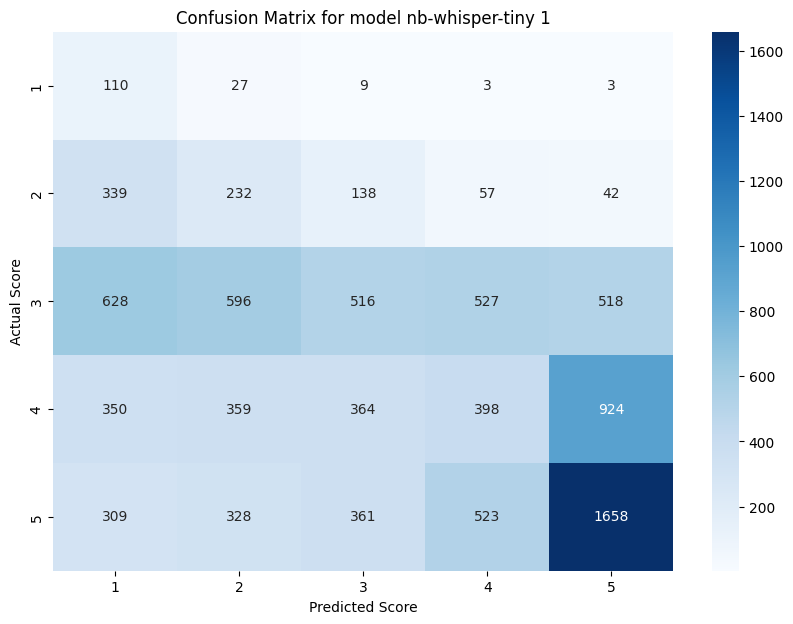

Confusion Matrix:
 [[ 110   27    9    3    3]
 [ 339  232  138   57   42]
 [ 628  596  516  527  518]
 [ 350  359  364  398  924]
 [ 309  328  361  523 1658]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0634   | 0.7237 |  0.821   |
|    2     |  0.1505   | 0.2871 |  0.7976  |
|    3     |  0.3718   | 0.1853 |  0.6629  |
|    4     |  0.2639   | 0.1662 |  0.6666  |
|    5     |  0.5272   | 0.5215 |  0.6772  |
|   Mean   |  0.2754   | 0.3768 |  0.7251  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0634,0.7237,0.8210
1,2,0.1505,0.2871,0.7976
2,3,0.3718,0.1853,0.6629
3,4,0.2639,0.1662,0.6666
4,5,0.5272,0.5215,0.6772
5,Mean,0.2754,0.3768,0.7251


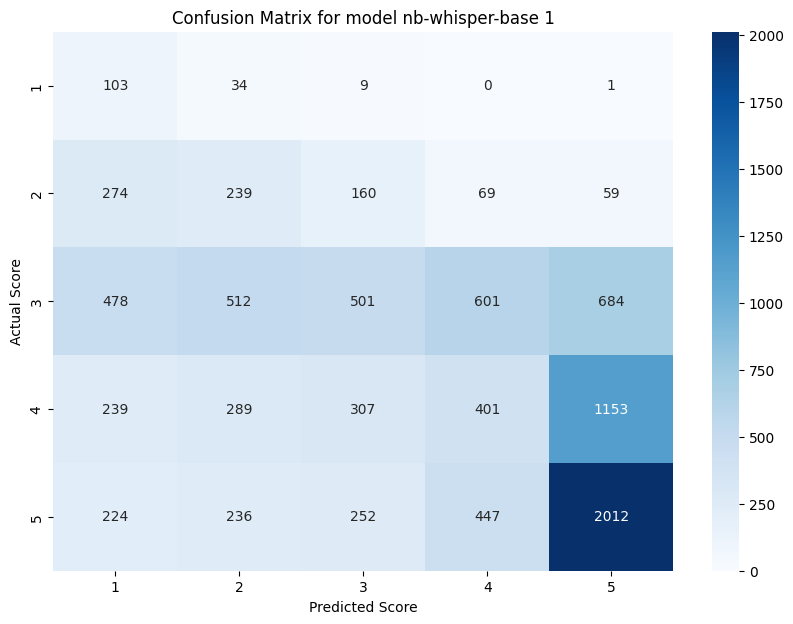

Confusion Matrix:
 [[ 103   34    9    0    1]
 [ 274  239  160   69   59]
 [ 478  512  501  601  684]
 [ 239  289  307  401 1153]
 [ 224  236  252  447 2012]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0781   | 0.7007 |  0.8644  |
|    2     |  0.1824   | 0.2984 |  0.8241  |
|    3     |  0.4076   | 0.1805 |  0.6765  |
|    4     |  0.2642   | 0.1679 |  0.6656  |
|    5     |  0.5147   | 0.6345 |  0.6708  |
|   Mean   |  0.2894   | 0.3964 |  0.7403  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0781,0.7007,0.8644
1,2,0.1824,0.2984,0.8241
2,3,0.4076,0.1805,0.6765
3,4,0.2642,0.1679,0.6656
4,5,0.5147,0.6345,0.6708
5,Mean,0.2894,0.3964,0.7403


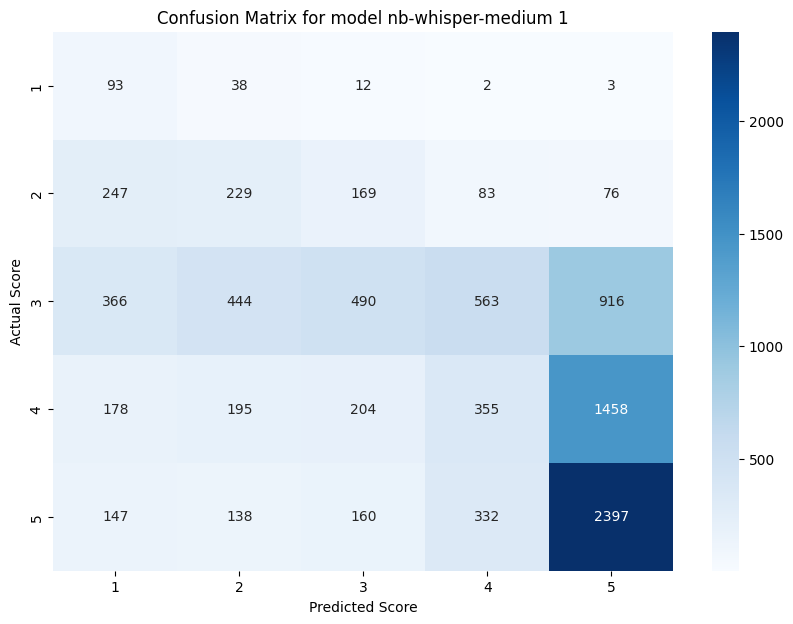

Confusion Matrix:
 [[  93   38   12    2    3]
 [ 247  229  169   83   76]
 [ 366  444  490  563  916]
 [ 178  195  204  355 1458]
 [ 147  138  160  332 2397]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0902   | 0.6284 |  0.8932  |
|    2     |  0.2193   | 0.2848 |  0.8505  |
|    3     |  0.4734   | 0.1763 |  0.6951  |
|    4     |  0.2659   | 0.1485 |  0.6756  |
|    5     |  0.4942   | 0.7552 |  0.6525  |
|   Mean   |  0.3086   | 0.3986 |  0.7534  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0902,0.6284,0.8932
1,2,0.2193,0.2848,0.8505
2,3,0.4734,0.1763,0.6951
3,4,0.2659,0.1485,0.6756
4,5,0.4942,0.7552,0.6525
5,Mean,0.3086,0.3986,0.7534


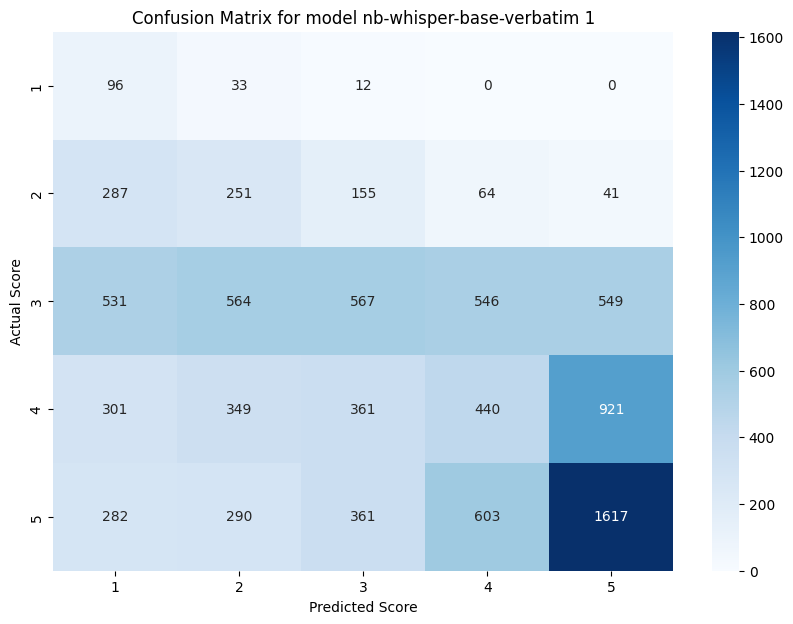

Confusion Matrix:
 [[  96   33   12    0    0]
 [ 287  251  155   64   41]
 [ 531  564  567  546  549]
 [ 301  349  361  440  921]
 [ 282  290  361  603 1617]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0641   | 0.6809 |  0.8432  |
|    2     |  0.1688   | 0.3145 |  0.8066  |
|    3     |  0.3894   | 0.2057 |  0.6661  |
|    4     |  0.2662   | 0.1855 |  0.6589  |
|    5     |  0.5169   | 0.5128 |  0.6696  |
|   Mean   |  0.2811   | 0.3799 |  0.7289  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0641,0.6809,0.8432
1,2,0.1688,0.3145,0.8066
2,3,0.3894,0.2057,0.6661
3,4,0.2662,0.1855,0.6589
4,5,0.5169,0.5128,0.6696
5,Mean,0.2811,0.3799,0.7289


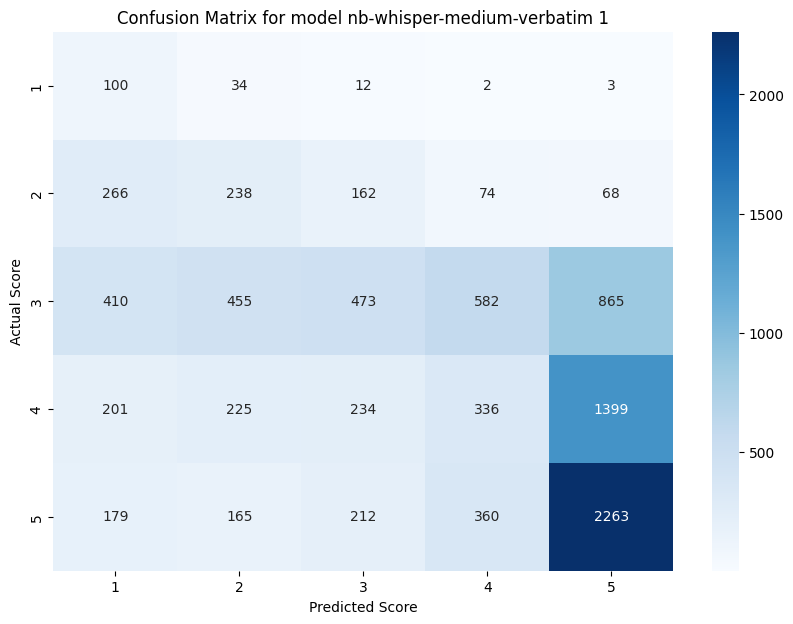

Confusion Matrix:
 [[ 100   34   12    2    3]
 [ 266  238  162   74   68]
 [ 410  455  473  582  865]
 [ 201  225  234  336 1399]
 [ 179  165  212  360 2263]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0865   | 0.6623 |  0.8812  |
|    2     |  0.2131   | 0.2946 |  0.8445  |
|    3     |  0.4328   | 0.1698 |  0.6853  |
|    4     |  0.2482   | 0.1403 |  0.6698  |
|    5     |  0.4922   | 0.7119 |  0.6511  |
|   Mean   |  0.2946   | 0.3958 |  0.7464  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0865,0.6623,0.8812
1,2,0.2131,0.2946,0.8445
2,3,0.4328,0.1698,0.6853
3,4,0.2482,0.1403,0.6698
4,5,0.4922,0.7119,0.6511
5,Mean,0.2946,0.3958,0.7464


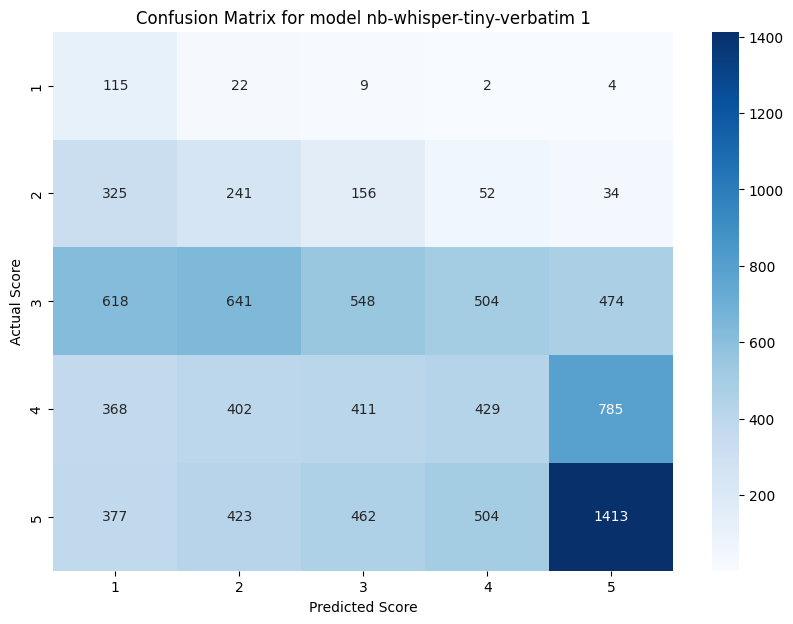

Confusion Matrix:
 [[ 115   22    9    2    4]
 [ 325  241  156   52   34]
 [ 618  641  548  504  474]
 [ 368  402  411  429  785]
 [ 377  423  462  504 1413]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0638   | 0.7566 |  0.8149  |
|    2     |  0.1394   | 0.2983 |  0.7795  |
|    3     |  0.3455   | 0.1968 |  0.6486  |
|    4     |  0.2877   | 0.1791 |  0.6751  |
|    5     |  0.5214   | 0.4445 |  0.6713  |
|   Mean   |  0.2716   | 0.3751 |  0.7179  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0638,0.7566,0.8149
1,2,0.1394,0.2983,0.7795
2,3,0.3455,0.1968,0.6486
3,4,0.2877,0.1791,0.6751
4,5,0.5214,0.4445,0.6713
5,Mean,0.2716,0.3751,0.7179


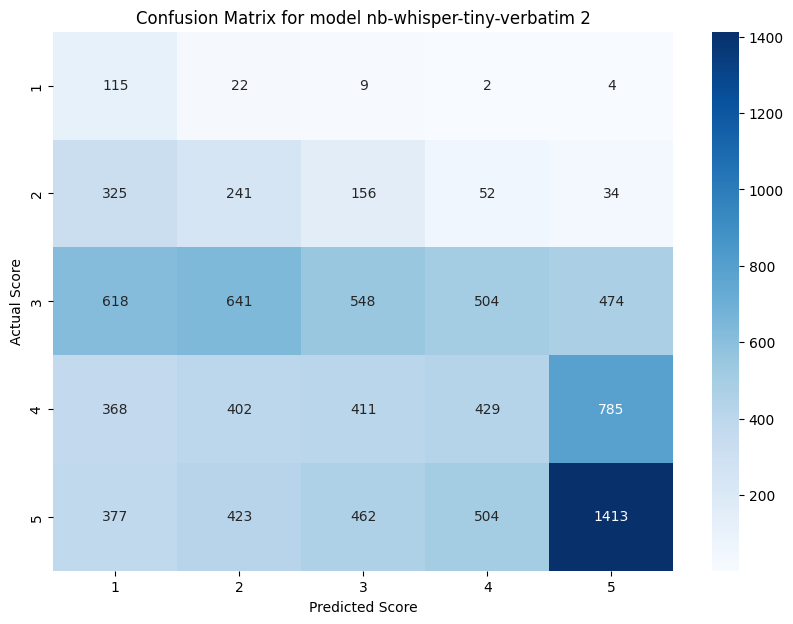

Confusion Matrix:
 [[ 115   22    9    2    4]
 [ 325  241  156   52   34]
 [ 618  641  548  504  474]
 [ 368  402  411  429  785]
 [ 377  423  462  504 1413]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0638   | 0.7566 |  0.8149  |
|    2     |  0.1394   | 0.2983 |  0.7795  |
|    3     |  0.3455   | 0.1968 |  0.6486  |
|    4     |  0.2877   | 0.1791 |  0.6751  |
|    5     |  0.5214   | 0.4445 |  0.6713  |
|   Mean   |  0.2716   | 0.3751 |  0.7179  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0638,0.7566,0.8149
1,2,0.1394,0.2983,0.7795
2,3,0.3455,0.1968,0.6486
3,4,0.2877,0.1791,0.6751
4,5,0.5214,0.4445,0.6713
5,Mean,0.2716,0.3751,0.7179


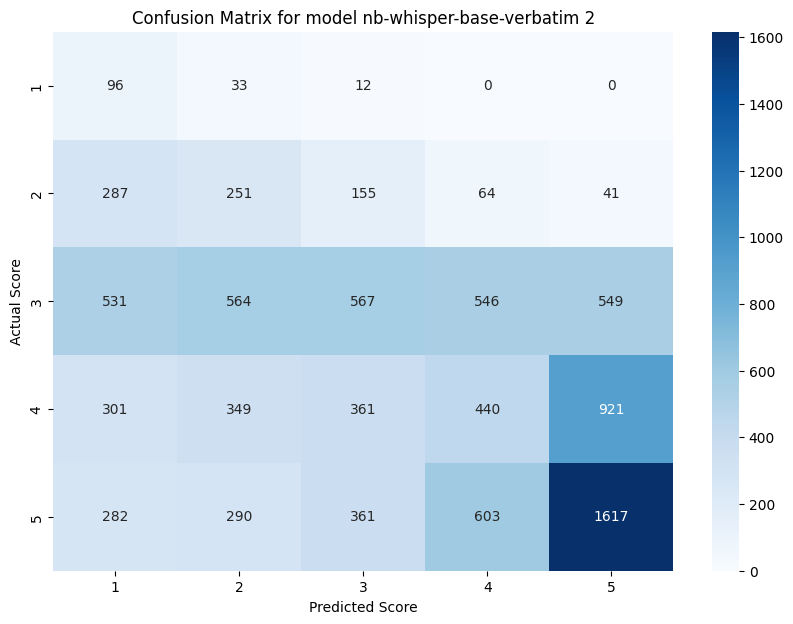

Confusion Matrix:
 [[  96   33   12    0    0]
 [ 287  251  155   64   41]
 [ 531  564  567  546  549]
 [ 301  349  361  440  921]
 [ 282  290  361  603 1617]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0641   | 0.6809 |  0.8432  |
|    2     |  0.1688   | 0.3145 |  0.8066  |
|    3     |  0.3894   | 0.2057 |  0.6661  |
|    4     |  0.2662   | 0.1855 |  0.6589  |
|    5     |  0.5169   | 0.5128 |  0.6696  |
|   Mean   |  0.2811   | 0.3799 |  0.7289  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0641,0.6809,0.8432
1,2,0.1688,0.3145,0.8066
2,3,0.3894,0.2057,0.6661
3,4,0.2662,0.1855,0.6589
4,5,0.5169,0.5128,0.6696
5,Mean,0.2811,0.3799,0.7289


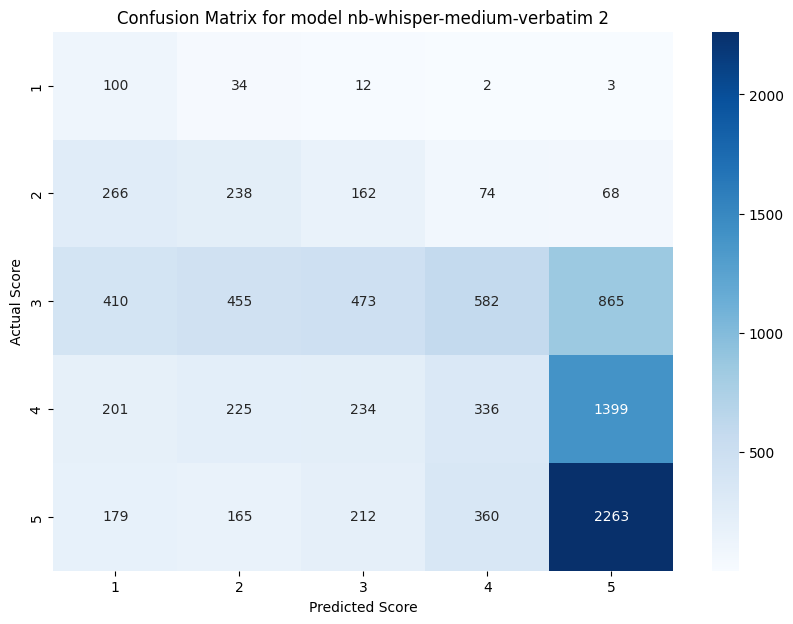

Confusion Matrix:
 [[ 100   34   12    2    3]
 [ 266  238  162   74   68]
 [ 410  455  473  582  865]
 [ 201  225  234  336 1399]
 [ 179  165  212  360 2263]]
+----------+-----------+--------+----------+
| Category | Precision | Recall | Accuracy |
+----------+-----------+--------+----------+
|    1     |  0.0865   | 0.6623 |  0.8812  |
|    2     |  0.2131   | 0.2946 |  0.8445  |
|    3     |  0.4328   | 0.1698 |  0.6853  |
|    4     |  0.2482   | 0.1403 |  0.6698  |
|    5     |  0.4922   | 0.7119 |  0.6511  |
|   Mean   |  0.2946   | 0.3958 |  0.7464  |
+----------+-----------+--------+----------+


,Category,Precision,Recall,Accuracy
0,1,0.0865,0.6623,0.8812
1,2,0.2131,0.2946,0.8445
2,3,0.4328,0.1698,0.6853
3,4,0.2482,0.1403,0.6698
4,5,0.4922,0.7119,0.6511
5,Mean,0.2946,0.3958,0.7464


In [7]:
# Make a script that goes tall the transcribed results and give accuracy, precition and




# compair all teh scores from teh model and chose witch model preforms the best
# smf.compare_transcriptions(file, empty_transcription_path) 

import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import self_made_functions as smf

empty_transcription_path = './Transcriptions/Empty_Transcriptions/'
directory = './Transcriptions'

dir_list =  os.listdir(directory)
for file in dir_list:
    if file.startswith('trans') and file.endswith('.csv'):
        model_name = file.split('_')[1]
        version = file.split('_v')[1].split('.c')[0]
        df = pd.read_csv(os.path.join(directory, file))
        word_score = df['OG Score']
        cer_score = df['CER Score']
        
        smf.conf_matrix(word_score=word_score, cer_score=cer_score, 
                        name=model_name, version=version, save=False, plot=True,
                        directory='./Transcriptions/Confution_matrix')
        
        metrics_df = smf.accuracy_precision_recall(word_score=word_score, cer_score=cer_score, name=model_name, 
                                    version=version, save=False, 
                                    directory='./Transcriptions/Metrics_results')
        




In [ ]:


test_path = './Transcriptions/transcriptions_base_v1.csv'


df_test = pd.read_csv(test_path)

word_score = df_test['OG Score']
cer_score = df_test['CER Score']


    


# conf_matrix(word_score, cer_score, 'base', 'v1', plot = True, save = True, directory = './Transcriptions')
# accuracy_precision_recall(word_score, cer_score, 'base', 'v1', save = False, directory = './Transcriptions')


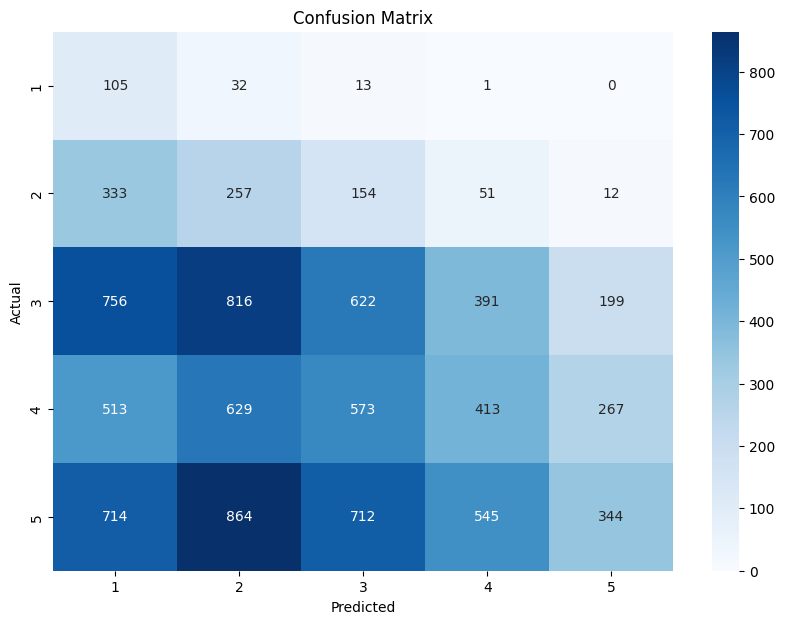

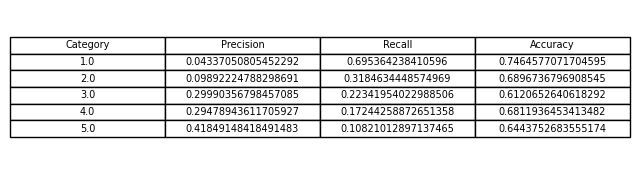

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from tabulate import tabulate

from pptx import Presentation
from pptx.util import Inches
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor

# Sample DataFrame with original and predicted scores
test_path = './Transcriptions/transcriptions_base_v1.csv'


df = pd.read_csv(test_path)

word_score = df_test['OG Score']
cer_score = df_test['CER Score']

# Generate confusion matrix
labels = [1, 2, 3, 4, 5]
conf_matrix = confusion_matrix(df['OG Score'], df['CER Score'], labels=labels)

# Convert confusion matrix to DataFrame and save using pd.DataFrame.to_csv
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
conf_matrix_df.to_csv('confusion_matrix.csv')

# Plot confusion matrix using seaborn and save the plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
conf_matrix_plot_path = 'confusion_matrix.png'
plt.savefig(conf_matrix_plot_path)  # Save the plot as a PNG file
plt.show()

# Calculate precision, recall, and accuracy for each category
metrics = {
    'Category': [],
    'Precision': [],
    'Recall': [],
    'Accuracy': []
}

for category in labels:
    y_true = df['OG Score'] == category
    y_pred = df['CER Score'] == category
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics['Category'].append(category)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['Accuracy'].append(accuracy)

metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV
metrics_df.to_csv('metrics.csv', index=False)

# Save metrics to an image
metrics_table_path = 'metrics_table.png'
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc = 'center', loc='center')
plt.savefig(metrics_table_path, bbox_inches='tight', pad_inches=0.1)

# Create PowerPoint presentation
prs = Presentation()

# Add title slide
slide_layout = prs.slide_layouts[0]  # 0 is the layout for title slide
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Model Evaluation Results"
subtitle.text = "Confusion Matrix and Metrics"

# Add confusion matrix slide
slide_layout = prs.slide_layouts[5]  # 5 is the layout for a blank slide
slide = prs.slides.add_slide(slide_layout)
title_shape = slide.shapes.title
title_shape.text = "Confusion Matrix"

# Add confusion matrix image
left = Inches(1)
top = Inches(2)
slide.shapes.add_picture(conf_matrix_plot_path, left, top, height=Inches(4.5))

# Add metrics table slide
slide_layout = prs.slide_layouts[5]  # 5 is the layout for a blank slide
slide = prs.slides.add_slide(slide_layout)
title_shape = slide.shapes.title
title_shape.text = "Metrics Table"

# Add metrics table image
left = Inches(1)
top = Inches(2)
slide.shapes.add_picture(metrics_table_path, left, top, height=Inches(2))

# Save the PowerPoint presentation
prs.save('model_evaluation_results.pptx')


1
2
3
4
5
Mean


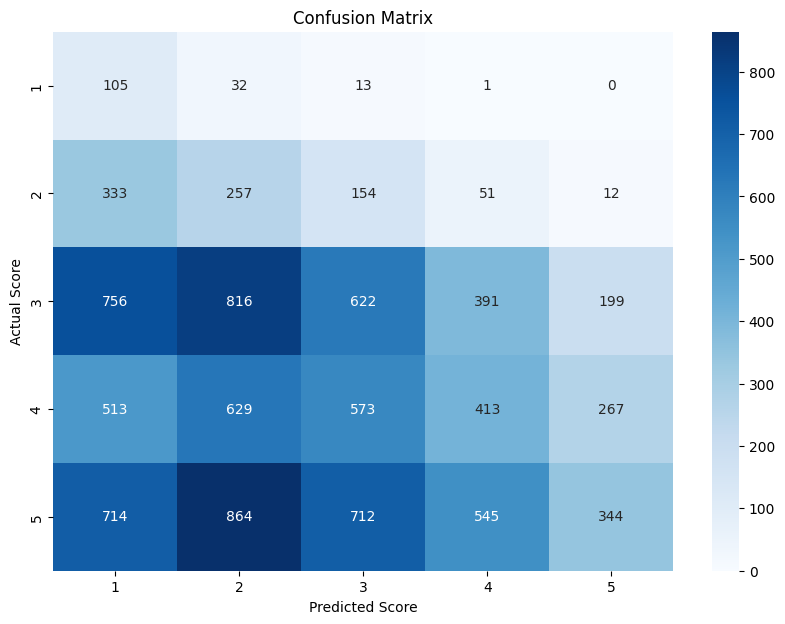

Confusion Matrix:
 [[105  32  13   1   0]
 [333 257 154  51  12]
 [756 816 622 391 199]
 [513 629 573 413 267]
 [714 864 712 545 344]]

Metrics for each category:
   Category  Precision    Recall  Accuracy
0        1   0.043371  0.695364  0.746458
1        2   0.098922  0.318463  0.689674
2        3   0.299904  0.223420  0.612065
3        4   0.294789  0.172443  0.681194
4        5   0.418491  0.108210  0.644375
5     Mean   0.231095  0.303580  0.674753

Average Precision: 0.23109544884481095


In [ ]:

import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns

test_path = './Transcriptions/transcriptions_base_v1.csv'


df_test = pd.read_csv(test_path)

word_score = df_test['OG Score']
cer_score = df_test['CER Score']


categories = [1, 2, 3, 4, 5] # Score category
cat_calc = [1, 2, 3, 4, 5, 'Mean']
# Calculate precision, recall, and accuracy
metrics = {
    'Category': [],
    'Precision': [],
    'Recall': [],
    'Accuracy': [],
}

for category in cat_calc:
    print(category)
    metrics['Category'].append(category)
    if category == 'Mean':
        metrics['Precision'].append(np.mean(metrics['Precision']))
        metrics['Recall'].append(np.mean(metrics['Recall']))
        metrics['Accuracy'].append(np.mean(metrics['Accuracy']))
        
    #     metrics_df['Recall'].mean()
    #     metrics_df['Accuracy'].mean()
    else:      
        y_true_score = word_score == category
        y_pred_score = cer_score == category
        
        precision = precision_score(y_true_score, y_pred_score)
        recall = recall_score(y_true_score, y_pred_score)
        accuracy = accuracy_score(y_true_score, y_pred_score)
        
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['Accuracy'].append(accuracy)
    

metrics_df = pd.DataFrame(metrics)

# Generate confusion matrix
conf_matrix = confusion_matrix(word_score, cer_score, labels=categories)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Score')
plt.ylabel('Actual Score')
plt.title('Confusion Matrix')
plt.show()

# Display confusion matrix and metrics
print("Confusion Matrix:\n", conf_matrix)
print("\nMetrics for each category:\n", metrics_df)
print("\nAverage Precision:", metrics_df['Precision'].mean())



#### Make a plot of all the score results

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('./Transcriptions/transcribed_df_whisper_tiny-verbatim.csv')

# Create scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data, x='OG Score', y='CER Score', hue='Word', palette='bright')

# Adding labels and title
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores for Different Words')

# Adding a diagonal line for reference
plt.plot([min(data['OG Score']), max(data['OG Score'])], [min(data['CER Score']), max(data['CER Score'])], color='gray', linestyle='--')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Transcriptions/transcribed_df_whisper_tiny-verbatim.csv'

### Plot the amount of transcribed words to see if there is one words with a big outlier 🌋

* Look for repeating words
* Sentences that are said instead of the target word

In [ ]:
# Script fra Phind.com
# path = './transcribed_df_whisper_base.csv'
# path = '/home/ajtruyen/language_master/transcribed_df_whisper_base.csv'
path = './transcribed_df_whisper_whisper-base_v2.csv'
# Step 1: Read the CSV file
df_transcribed = pd.read_csv(path) # load data fram from saved csv file

# Step 2: Count words in the "Transcribed" column
df_transcribed['WordCount'] = df_transcribed['Transcribed'].str.split().str.len()

# Step 3: Identify outliers (assuming any count > 1 is an outlier)
outliers = df_transcribed[df_transcribed['WordCount'] > 1]

# Find the index numbers of the outliers
outlier_indices = outliers.index.tolist()

# Print the index numbers of the outliers
print("Index numbers of outliers:", outlier_indices)

Index numbers of outliers: [11, 60, 62, 63, 64, 67, 72, 76, 80, 82, 84, 88, 94, 97, 169, 172, 182, 208, 241, 246, 250, 251, 266, 296, 351, 355, 356, 367, 372, 373, 377, 379, 381, 383, 384, 385, 387, 389, 392, 394, 395, 399, 413, 424, 428, 429, 443, 451, 505, 525, 545, 546, 557, 558, 563, 567, 569, 573, 585, 594, 603, 609, 614, 623, 643, 645, 646, 651, 655, 661, 662, 671, 675, 677, 685, 693, 716, 721, 742, 749, 750, 757, 777, 804, 810, 844, 848, 855, 875, 878, 887, 902, 910, 914, 916, 917, 924, 932, 938, 941, 945, 959, 964, 965, 966, 976, 982, 1011, 1058, 1063, 1064, 1077, 1084, 1096, 1100, 1112, 1121, 1132, 1137, 1148, 1156, 1172, 1177, 1200, 1223, 1237, 1248, 1259, 1280, 1315, 1335, 1360, 1370, 1383, 1388, 1434, 1435, 1441, 1457, 1461, 1470, 1508, 1543, 1546, 1548, 1562, 1587, 1612, 1642, 1676, 1702, 1713, 1718, 1722, 1728, 1733, 1735, 1738, 1750, 1755, 1760, 1772, 1786, 1787, 1790, 1791, 1796, 1798, 1813, 1815, 1823, 1829, 1831, 1839, 1843, 1846, 1852, 1892, 1942, 1962, 1972, 1974, 1

#### Plot the outliers in different plots to showcase the frequency of more than one transcribed word

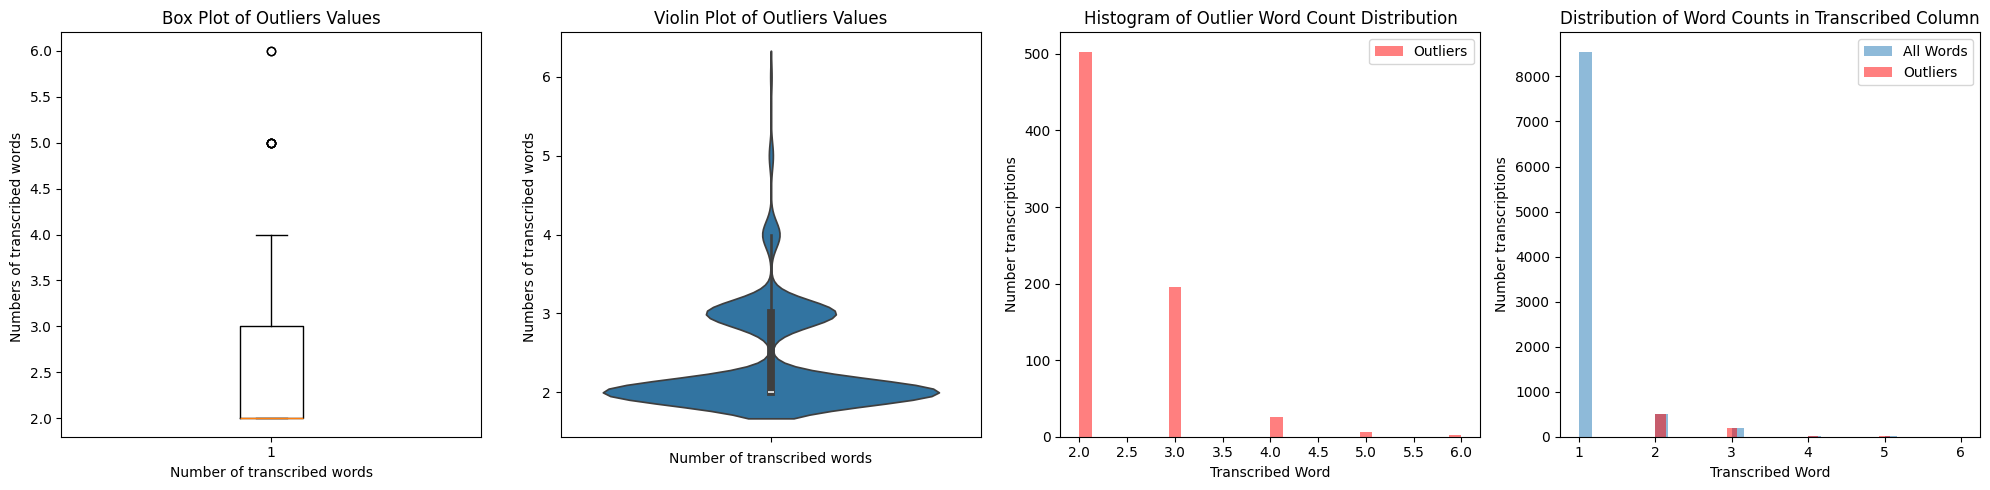

In [ ]:
# Help from ChatGPT generated code to show of outlier result in different plots
# Create a figure and axis with 1 row and 3 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Box plot
# axs[0].boxplot(df['WordCount'])
# axs[0].set_title('Box Plot of Values with Outliers')
axs[0].boxplot(outliers['WordCount'])
axs[0].set_title('Box Plot of Outliers Values')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Numbers of transcribed words ')
axs[0].set_xlabel('Number of transcribed words')

# Violin plot
# sns.violinplot(y=df['WordCount'], ax=axs[1])
# axs[1].set_title('Violin Plot of Values with Outliers')

sns.violinplot(y=outliers['WordCount'], ax=axs[1])
axs[1].set_title('Violin Plot of Outliers Values')
axs[1].set_ylabel('Numbers of transcribed words ')
axs[1].set_xlabel('Number of transcribed words')

# Histogram only outliers
# axs[2].hist(df['WordCount'], bins=30, alpha=0.5, label='All Words')
axs[2].hist(outliers['WordCount'], bins=30, alpha=0.5, color='red', label='Outliers')
axs[2].set_title('Histogram of Outlier Word Count Distribution')
axs[2].set_xlabel('Transcribed Word')
axs[2].set_ylabel('Number transcriptions')
axs[2].legend()

# Histogram all transcriptions
axs[3].hist(df_transcribed['WordCount'], bins=30, alpha=0.5, label='All Words')
axs[3].hist(outliers['WordCount'], bins=30, alpha=0.5, color='red', label='Outliers')
axs[3].set_title('Distribution of Word Counts in Transcribed Column')
axs[3].set_xlabel('Transcribed Word')
axs[3].set_ylabel('Number transcriptions')
axs[3].legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


#### Finding correspondence between transcribed df and original df

In [ ]:
# Finding correspondence between transcribed df and original df
weird_idx = 9147
filename_word = df_transcribed['File name'][weird_idx]

# Find the corresponding index in the original DataFrame
corresponding_index = df_fin[df_fin['File name'].str.contains(filename_word)].index
print('corresponding_index u/ item()::', corresponding_index, '\ncorresponding_index m/ item():', corresponding_index.item(),'\n')
print(df_fin.iloc[corresponding_index.item()], '\n') # La til .item() for at den skulle skrives ut med overskriftene vertikalt
print(df_transcribed.iloc[9147])

# # The corresponding row in the original data frame | samme som over bare mindre linjer og utskriften blir anderledes
# corresponding_row = df_fin[df_fin['File name'].str.contains(filename_word)]
# print(corresponding_row)
# print('----------------')
# print(df.iloc[weird_idx])



corresponding_index u/ item():: Index([9182], dtype='int64') 
corresponding_index m/ item(): 9182 

File name           d05_prins.wav
Score                           5
Prosody                       NaN
Noise/Disruption              1.0
Pre-speech noise              1.0
Repetition                    NaN
Word                        prins
Pronunciation           p r I n s
pronScores              1 1 1 1 1
Assessor                  Jeanett
Name: 9182, dtype: object 

File name                                                         d05_prins.wav
Word                                                                      prins
Transcribed                                            Trinn selv var det prins
Character Error Rate (CER)                                             0.791667
Score                                                                         5
CER Output                    CharacterOutput(references=[['T', 'r', 'i', 'n...
WordCount                                           

#### Plot the outlier wave to analyze it
In this case it looks like they might talk more than just the required word

Word nr 9182 : prins
Trans : {'text': ' Trinn selv var det prins'}
Score : 5
len(audio) : 48000
Type : <class 'numpy.ndarray'>
Clip duration :  3.0


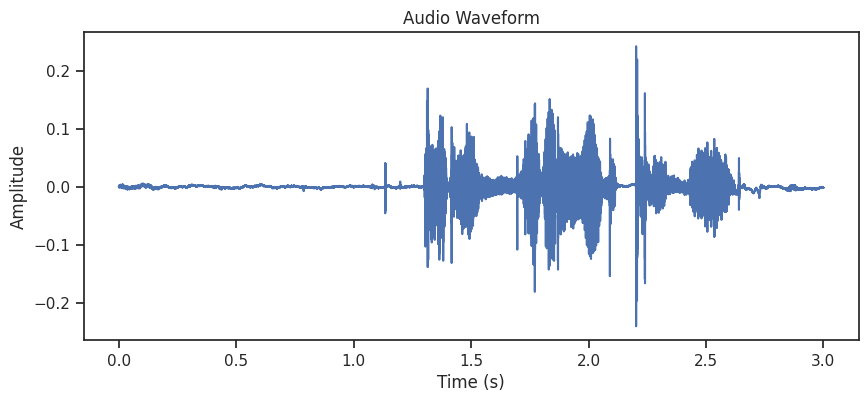

In [ ]:
check_specific_word(df=df_transcribed, wave_number=corresponding_index.item(), plot=True)




#### Plot all the outlier words in a subplot

TODO: Bare plott de tingene som har mere enn 3 ord i seg
NB! Audio Waveform nr: 428, 804, 2017, 2837 er wonky | Audio Waveform nr: 3443 er nok noe annet enn ordet dør

In [ ]:
# outlier_indices = [11, 60, 62, 63, 64, 67, 72, 76, 80, 82, 84, 88, 94, 97, 169, 172, 182, 208, 241, 246, 250, 251, 266, 296, 351, 355, 356, 367, 372, 373, 377, 379, 381, 383, 384, 385, 387, 389, 392, 394]#, 395, 399, 413, 424, 428, 429, 443, 451, 505, 525, 545, 546, 557, 558, 563, 567, 569, 573, 585, 594, 603, 609, 614, 623, 643, 645, 646, 651, 655, 661, 662, 671, 675, 677, 685, 693, 716, 721, 742, 749, 750, 757, 777, 804, 810, 844, 848, 855, 875, 878, 887, 902, 910, 914, 916, 917, 924, 932, 938, 941, 945, 959, 964, 965, 966, 976, 982, 1011, 1058, 1063, 1064, 1077, 1084, 1096, 1100, 1112, 1121, 1132, 1137, 1148, 1156, 1172, 1177, 1200, 1223, 1237, 1248, 1259, 1280, 1315, 1335, 1360, 1370, 1383, 1388, 1434, 1435, 1441, 1457, 1461, 1470, 1508, 1543, 1546, 1548, 1562, 1587, 1612, 1642, 1676, 1702, 1713, 1718, 1722, 1728, 1733, 1735, 1738, 1750, 1755, 1760, 1772, 1786, 1787, 1790, 1791, 1796, 1798, 1813, 1815, 1823, 1829, 1831, 1839, 1843, 1846, 1852, 1892, 1942, 1962, 1972, 1974, 1981, 1986, 1988, 1996, 2008, 2016, 2017, 2022, 2024, 2027, 2031, 2040, 2052, 2067, 2076, 2081, 2090, 2092, 2112, 2139, 2140, 2143, 2180, 2187, 2193, 2199, 2200, 2212, 2213, 2254, 2271, 2298, 2310, 2312, 2316, 2328, 2370, 2375, 2387, 2401, 2416, 2450, 2509, 2516, 2519, 2521, 2522, 2546, 2551, 2555, 2561, 2570, 2574, 2591, 2604, 2611, 2617, 2620, 2627, 2657, 2676, 2696, 2764, 2793, 2819, 2828, 2836, 2837, 2838, 2856, 2860, 2866, 2901, 2919, 2960, 2969, 2973, 2982, 2987, 2988, 2989, 2996, 3003, 3005, 3008, 3010, 3012, 3015, 3019, 3022, 3024, 3027, 3030, 3034, 3052, 3054, 3074, 3082, 3120, 3198, 3257, 3287, 3406, 3418, 3425, 3432, 3433, 3443, 3450, 3459, 3496, 3515, 3522, 3524, 3525, 3546, 3550, 3552, 3563, 3584, 3612, 3616, 3622, 3626, 3636, 3704, 3710, 3723, 3731, 3794, 3811, 3812, 3815, 3826, 3876, 3881, 3885, 3891, 3918, 3920, 3922, 3949, 3960, 3968, 3978, 4047, 4075, 4103, 4106, 4113, 4118, 4120, 4132, 4142, 4145, 4147, 4148, 4158, 4171, 4173, 4180, 4189, 4196, 4199, 4219, 4234, 4237, 4307, 4308, 4311, 4315, 4316, 4318, 4319, 4320, 4323, 4328, 4330, 4344, 4345, 4346, 4349, 4350, 4351, 4352, 4361, 4409, 4445, 4525, 4569, 4611, 4636, 4639, 4654, 4660, 4675, 4685, 4716, 4728, 4736, 4753, 4810, 4837, 4874, 4875, 4876, 4885, 4886, 4893, 4896, 4909, 4925, 4944, 4967, 4985, 4992, 5012, 5018, 5046, 5055, 5065, 5067, 5070, 5071, 5076, 5079, 5086, 5089, 5091, 5116, 5128, 5141, 5149, 5156, 5158, 5183, 5188, 5194, 5196, 5204, 5209, 5213, 5216, 5223, 5226, 5271, 5284, 5292, 5301, 5302, 5304, 5307, 5311, 5314, 5318, 5321, 5322, 5323, 5325, 5368, 5406, 5408, 5414, 5420, 5426, 5484, 5499, 5514, 5521, 5559, 5561, 5566, 5590, 5607, 5653, 5680, 5687, 5695, 5702, 5710, 5758, 5769, 5770, 5772, 5787, 5789, 5797, 5800, 5839, 5844, 5846, 5853, 5870, 5872, 5885, 5900, 5922, 5932, 5949, 5951, 5958, 5963, 5964, 5967, 5981, 5999, 6005, 6006, 6014, 6123, 6133, 6154, 6164, 6229, 6244, 6250, 6257, 6299, 6301, 6322, 6337, 6350, 6389, 6391, 6398, 6463, 6474, 6477, 6500, 6506, 6509, 6511, 6539, 6626, 6643, 6644, 6646, 6649, 6650, 6652, 6694, 6763, 6767, 6789, 6802, 6815, 6816, 6818, 6820, 6832, 6834, 6835, 6836, 6838, 6841, 6846, 6849, 6859, 6861, 6917, 6949, 6961, 7000, 7010, 7023, 7024, 7033, 7041, 7065, 7079, 7080, 7095, 7101, 7103, 7109, 7112, 7113, 7117, 7118, 7119, 7120, 7129, 7133, 7143, 7150, 7151, 7171, 7177, 7180, 7210, 7220, 7249, 7252, 7254, 7291, 7298, 7300, 7309, 7318, 7323, 7329, 7330, 7332, 7334, 7335, 7339, 7344, 7345, 7346, 7347, 7354, 7372, 7374, 7378, 7383, 7386, 7387, 7391, 7423, 7572, 7573, 7574, 7577, 7580, 7583, 7598, 7602, 7603, 7606, 7610, 7613, 7615, 7658, 7673, 7678, 7679, 7714, 7781, 7802, 7817, 7852, 7875, 7876, 7880, 7883, 7888, 7895, 7898, 7900, 7911, 7912, 7913, 7916, 8007, 8016, 8020, 8022, 8025, 8037, 8054, 8069, 8074, 8081, 8090, 8096, 8103, 8105, 8108, 8113, 8118, 8119, 8127, 8132, 8136, 8144, 8161, 8168, 8172, 8187, 8191, 8200, 8215, 8216, 8220, 8224, 8231, 8240, 8250, 8256, 8260, 8270, 8275, 8276, 8285, 8293, 8303, 8318, 8346, 8408, 8426, 8429, 8433, 8441, 8453, 8455, 8456, 8459, 8463, 8467, 8476, 8479, 8484, 8491, 8545, 8564, 8590, 8622, 8643, 8669, 8683, 8710, 8731, 8754, 8764, 8797, 8826, 8915, 8950, 8977, 8985, 8995, 9003, 9005, 9009, 9012, 9015, 9016, 9017, 9045, 9050, 9053, 9130, 9147, 9191, 9203, 9221, 9223, 9227, 9228, 9255]

out = outliers[outliers['WordCount'] > 2] # de med flere transkripsjoner enn 2
out_idx = out.index.tolist()
print('outlier_indices:', len(out_idx), out_idx)

lst = out_idx

sr = sampling_rate

#Plot
# # Set the number of columns for subplots
# num_cols = 4
# num_rows = len(lst) // num_cols + (len(lst) % num_cols > 0)

# # Create a new figure for subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))

# # Flatten axes if there's only one row
# if num_rows == 1:
#     axes = [axes]

# # Iterate through lst and plot each waveform
# for index, i in enumerate(lst):
#     wv_path = data_path + 'speech16khz/' + df_transcribed['File name'][i]
#     audio = whisper.load_audio(wv_path, sr)
#     sec = len(audio) / sr
    
#     # Plot the waveform
#     row_index = index // num_cols
#     col_index = index % num_cols
#     ax = axes[row_index][col_index]
    
#     time = np.linspace(0, sec, num=len(audio))
#     sns.lineplot(x=time, y=audio, ax=ax)
    
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Amplitude')
#     ax.set_title(f'Audio Waveform {i}')

#     # Add annotation below the subplot
#     info_text = f'Word: {df_transcribed["Word"][i]}\nTranscription: {df_transcribed["Transcribed"][i]}\nScore: {df_transcribed["Score"][i]}'
#     ax.annotate(info_text, xy=(0.5, -0.3), xycoords='axes fraction', ha='right', va='center', fontsize=10)

# # Adjust layout
# plt.tight_layout()
# plt.show()

### Functions that are not really used
#### Finding the length of the sound clips
By printing all the audio clip lengths, we can see if there is much variation. In this case there is not, and we find the max length to be 3 seconds. This is interesting to know cause whispers default clip length is set to 30 seconds. 

The different audio clip lengths commented out: 
<!-- [3.0, 2.8735, 2.539375, 2.4181875, 2.553, 2.5725, 2.606625, 2.4406875, 2.54975, 2.585, 2.4143125, 2.4781875, 2.454875, 2.5303125, 2.481875, 2.180375, 2.9495625, 2.541125, 1.5035, 2.8479375, 2.471375, 2.403, 2.4455625, 2.020125, 2.425875, 2.54225, 2.3551875, 2.56175, 2.4603125, 2.5178125, 2.578625, 2.5158125, 2.4476875, 2.4734375, 2.558, 2.8545625, 2.4821875, 2.394375, 1.58475, 2.50425, 2.5286875, 2.5451875, 2.4861875, 2.567125, 2.3831875, 2.5711875, 2.3665625, 2.5890625, 2.507, 2.5525625, 2.5225625, 2.4775, 2.5298125, 2.5041875, 2.4031875, 2.3279375, 2.424125, 2.42025, 2.352125, 2.549875, 2.517625, 2.542375, 2.575875, 2.511125, 2.5146875, 2.4409375, 2.55625, 2.5118125, 2.5399375, 2.558625, 2.46725, 2.56725, 2.5169375, 2.508, 2.4509375, 2.419875, 2.4621875, 2.5103125, 2.5654375, 2.39975, 2.534125, 2.33375, 2.42075, 2.57125, 2.5566875, 2.3765, 2.47025, 2.4965625, 2.492125, 2.547, 2.5599375, 2.58075, 2.3855, 2.593, 2.34925, 2.537125, 2.56125, 2.488125, 2.4499375, 2.525375, 2.6961875, 2.511625, 2.374, 2.4631875, 2.355875, 2.3549375, 2.4884375, 2.323875, 2.6651875, 2.405, 2.5551875, 2.437625, 2.548125, 2.5293125, 2.6595625, 2.460875, 2.482375, 2.53275, 2.5670625, 2.5818125, 2.955625, 1.9504375, 2.5091875, 2.4386875, 2.547625, 2.57075, 0.8881875, 2.541, 2.6920625, 2.4554375, 2.4733125, 2.8569375, 2.4786875, 2.586375, 2.4345, 2.531375, 2.5305, 2.51325, 2.443875, 2.5184375, 2.378625, 2.4990625, 2.3715, 2.490625, 2.509, 2.5373125, 2.5514375, 2.5851875, 2.4881875, 2.4104375, 2.4583125, 2.5550625, 2.5836875, 2.457, 2.5783125, 1.4976875, 2.626, 2.5141875, 2.5959375, 2.3809375, 2.463, 2.4753125, 2.4816875, 2.5424375, 2.532125, 2.205875, 2.531625, 2.4755625, 2.508375, 2.34425, 2.5245625, 2.5150625, 1.5499375, 2.608625, 2.697875, 2.44125, 2.4728125, 2.4286875, 2.3903125, 2.4815625, 2.4891875] -->

In [ ]:
def get_clip_lenght():    
    sampling_rate = 16000
    clip_len = []
    for i, row in df_fin.iterrows():
        wave_path= wv_path + row['File name'] # find the data path
        audio = whisper.load_audio(wave_path) # load the audio
        sec =  len(audio)/sampling_rate # find the length of the audio
        
        if  sec not in clip_len:
            clip_len.append(sec)
    print('All the different lengths of the audio clips:', clip_len)
    print('Max audio clip length:', max(clip_len), 'seconds')
    return None

# Own version to extract the unique words spoken -- NB! A "Word" column existed 
# unique_labels = df['File name'].unique() <- Cant find the uniq word due to longer lames
def get_unique_words(df):
    new_word = ''
    lst_words = []

    for i in range(len(df_fin['File name'])):
        # print(i)
        current_word = df_fin['File name'][i][4:-4]
        # Check and save all the different words:
        if new_word != current_word:
            new_word = current_word
            lst_words.append(new_word)
            
    # print(lst_words)

['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'd01', 'd02', 'd03', 'd04', 'd05', 'd06', 'd07', 'd08', 'd09', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19']
